In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Path to save the model and logs
model_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/VGG16_best_model.h5'
log_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/VGG16_training_log.csv'

# Setup ModelCheckpoint to save the model with the best validation accuracy
model_checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# Setup CSVLogger to save the training data
csv_logger = CSVLogger(log_path, append=True)


In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K  # Import keras.backend as K


def get_f1_score(precision, recall):
    def f1_score(y_true, y_pred):
        p = precision(y_true, y_pred)
        r = recall(y_true, y_pred)
        return 2 * ((p * r) / (p + r + K.epsilon()))
    return f1_score

# Instantiate Precision and Recall metrics
precision_metric = Precision()
recall_metric = Recall()

# Create a custom F1 Score metric
f1_score_metric = get_f1_score(precision_metric, recall_metric)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load CIFAR-10 data
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values and resize images for VGG16
train_images = tf.image.resize(train_images, [75, 75]).numpy()  # Resize images
test_images = tf.image.resize(test_images, [75, 75]).numpy()

train_images = preprocess_input(train_images)  # Preprocess for VGG16
test_images = preprocess_input(test_images)

# Convert labels to categorical
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for augmenting training data
train_datagen = ImageDataGenerator(
    rotation_range=40,       # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # Randomly apply shearing transformations
    zoom_range=0.2,          # Randomly zoom into images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in new pixels in case of zoom or rotation
)

# No augmentation for the validation data, only rescaling
test_datagen = ImageDataGenerator()


In [ ]:
# Prepare generators for training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

In [ ]:
# Load the VGG16 model without the top layer to add a custom classifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze the convolutional base

# Create a new top layer that matches the number of CIFAR-10 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Add these metrics to your model compilation step
# Compile the model with custom defined metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_metric, recall_metric, f1_score_metric])

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Train the model using the data augmentation generators
#model.fit(train_generator,
#           epochs=1,
#           validation_data=validation_generator)
history = model.fit(train_generator,
                   epochs=30,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint, csv_logger])

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 1.2223 - accuracy: 0.6211 - precision: 0.7062 - recall: 0.5223 - f1_score: 0.5553
Epoch 1: val_accuracy improved from -inf to 0.73300, saving model to /content/drive/My Drive/Colab Notebooks/contentfilter/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 156s 96ms/step - loss: 1.2223 - accuracy: 0.6211 - precision: 0.7062 - recall: 0.5223 - f1_score: 0.5553 - val_loss: 0.7715 - val_accuracy: 0.7330 - val_precision: 0.7990 - val_recall: 0.6682 - val_f1_score: 0.7336
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.9544 - accuracy: 0.6712 - precision: 0.7634 - recall: 0.5725 - f1_score: 0.6529
Epoch 2: val_accuracy improved from 0.73300 to 0.74960, saving model to /content/drive/My Drive/Colab Notebooks/contentfilter/best_model.h5
1563/1563 [==============================] - 132s 84ms/step - loss: 0.9544 - accuracy: 0.6712 - precision: 0.7634 - recall: 0.5725 - f1_score: 0.6529 - val_loss: 0.7350 - val_accuracy: 0.7496 - val_precision: 0.8109 - val_recall: 0.6924 - val_f1_score: 0.7416
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.6846 - precision: 0.7737 - recall: 0.5892 - f1_score: 0.6700
Epoch 3: val_accuracy improved f

In [ ]:
import pandas as pd

# Define the path to the CSV file
log_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/VGG16_training_log.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(log_path)


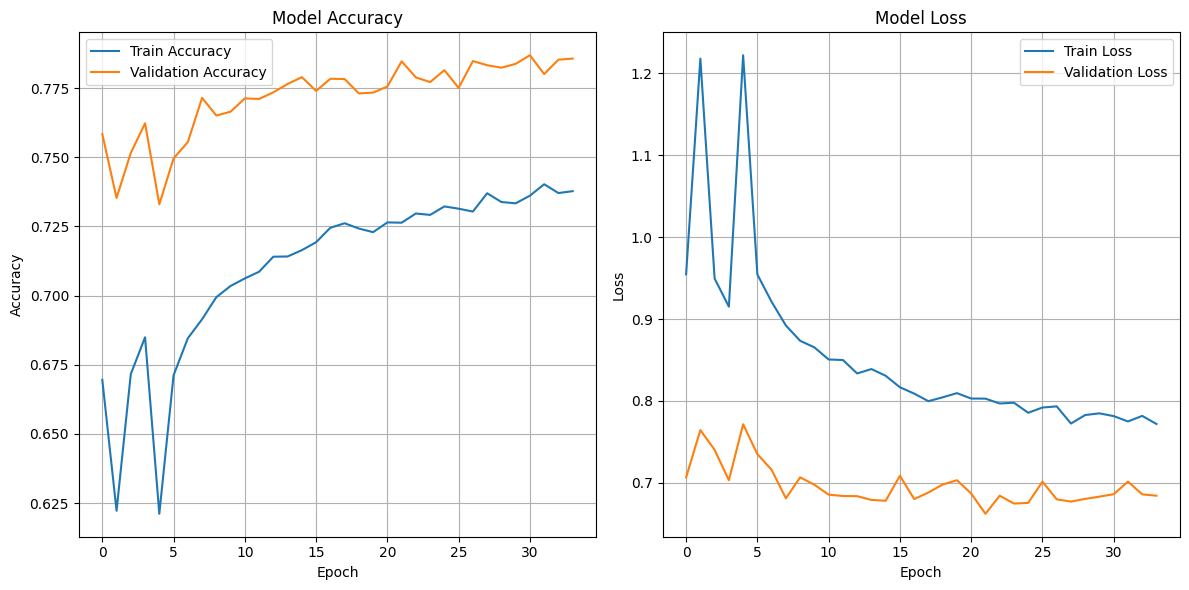

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)  # Enable grid

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)  # Enable grid

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from tensorflow.keras.models import load_model

# Define the path to the saved model
model_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/VGG16_best_model.h5'

# Load the model with custom objects
model = load_model(model_path, custom_objects={'f1_score': f1_score})


In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

313/313 [==============================] - 759s 2s/step


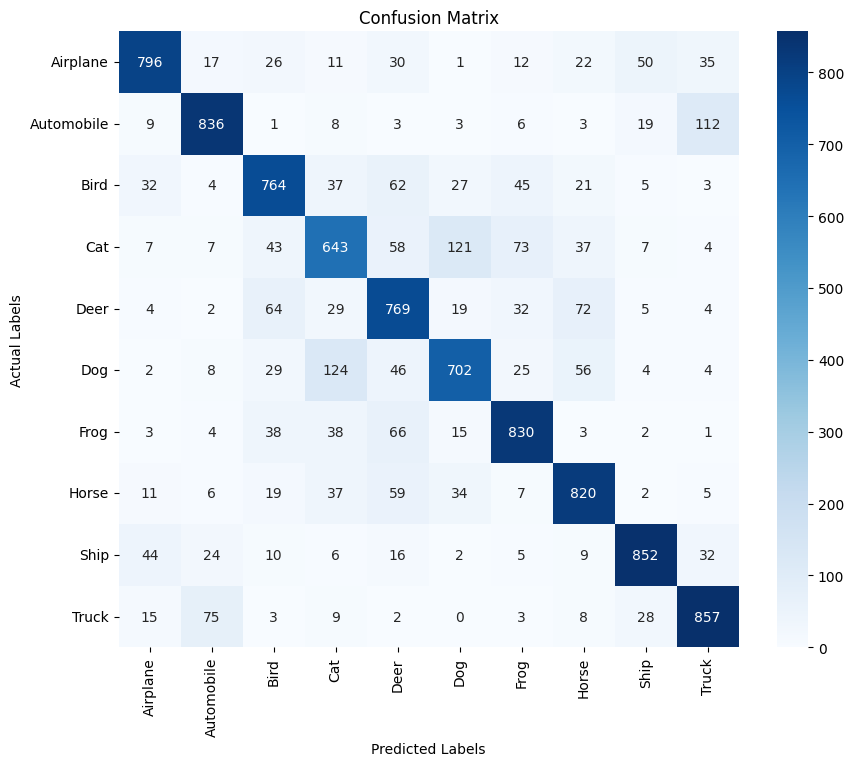

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have test_images and test_labels, and a trained model named 'model'
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()



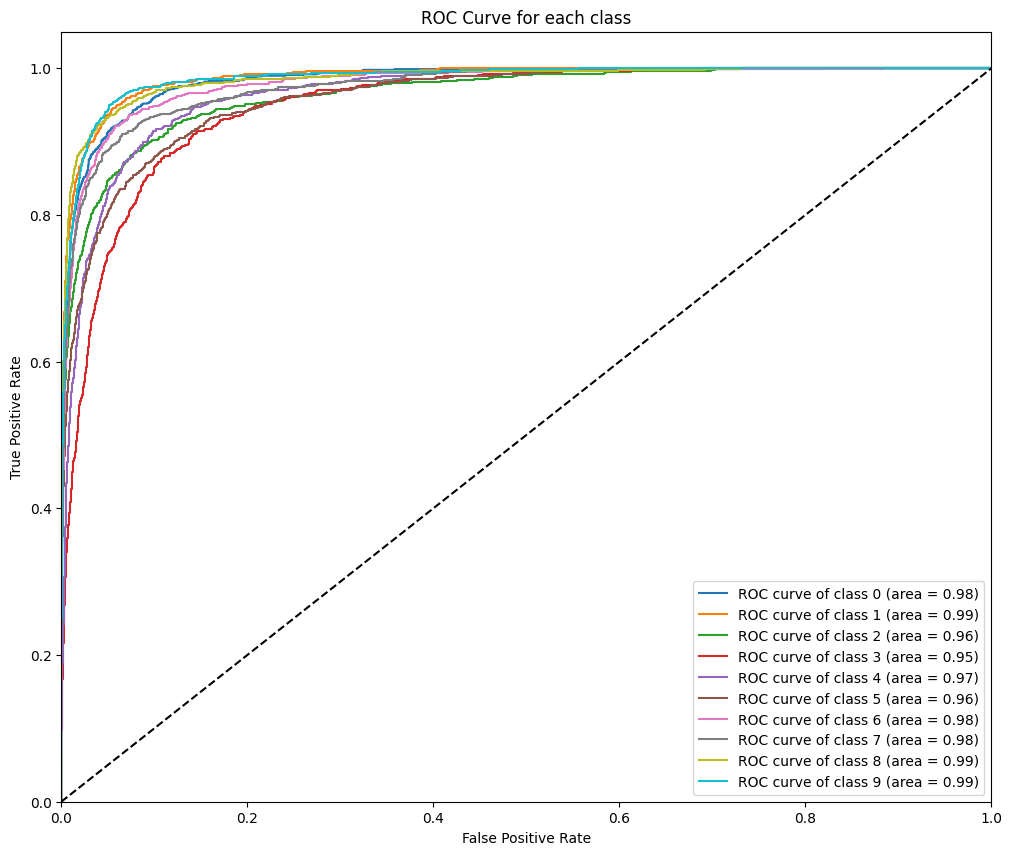

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
test_labels_binarized = label_binarize(test_true_classes, classes=np.arange(10))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


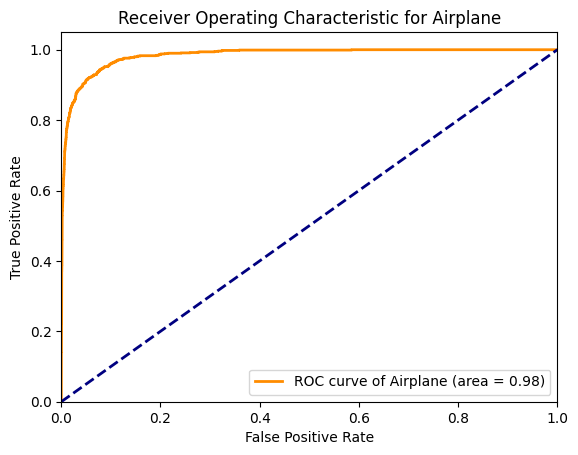

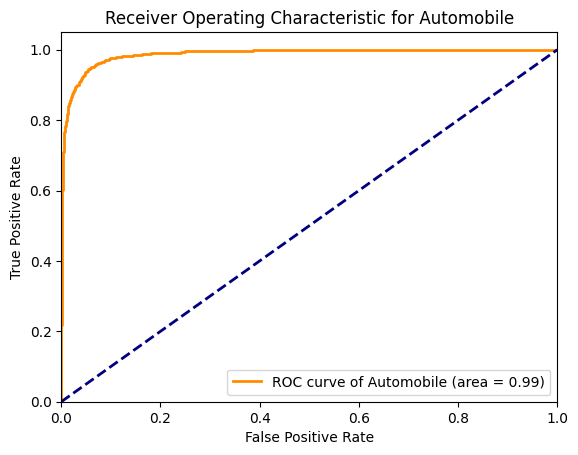

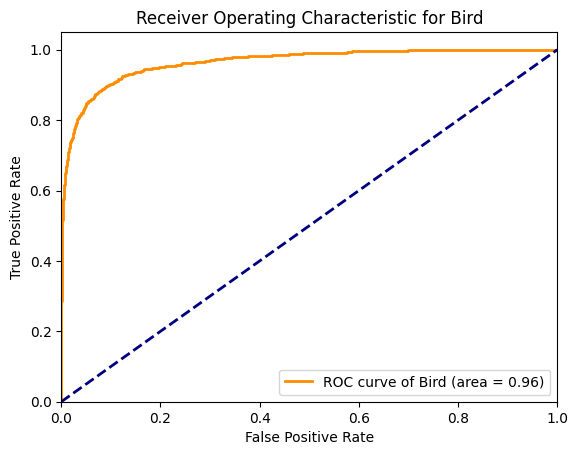

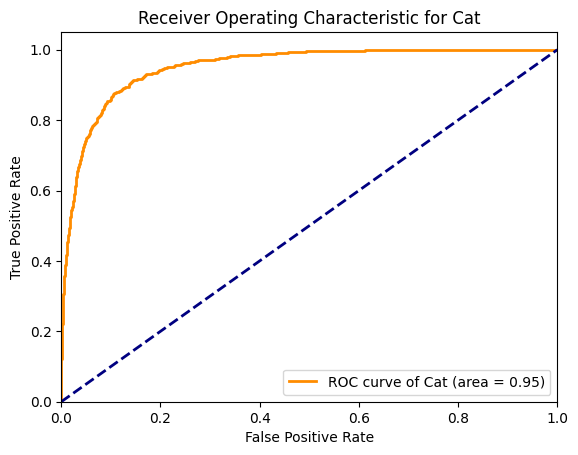

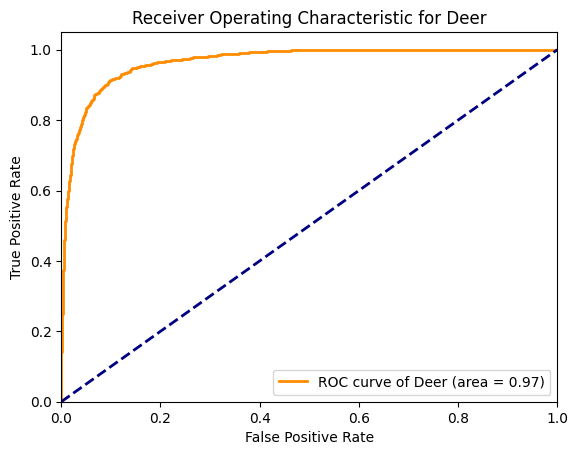

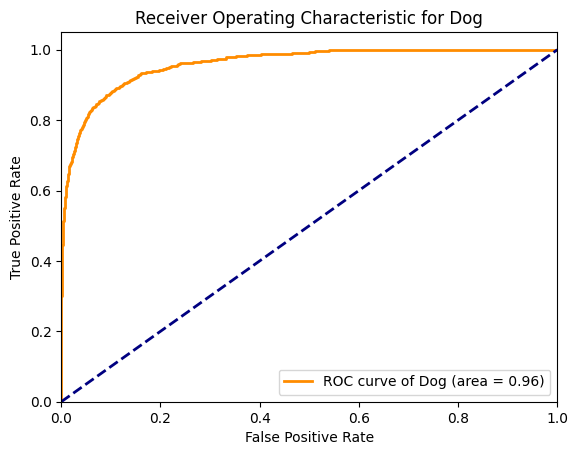

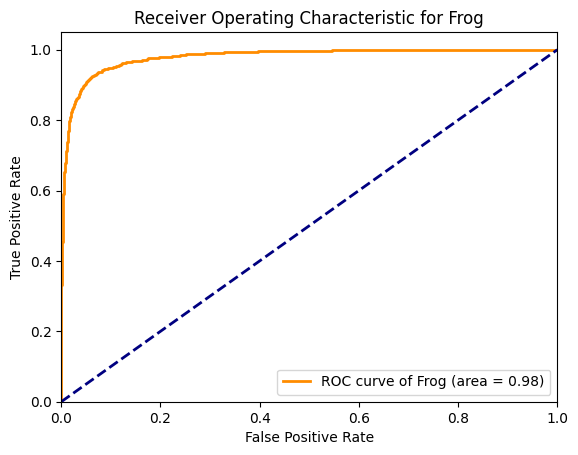

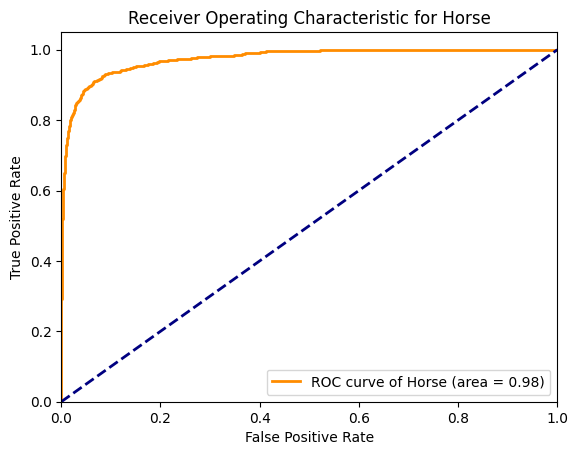

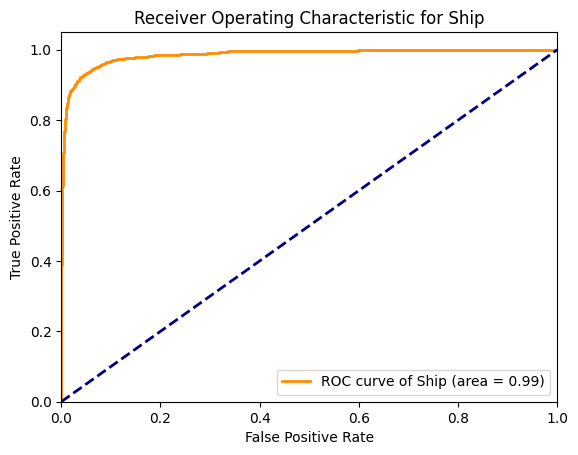

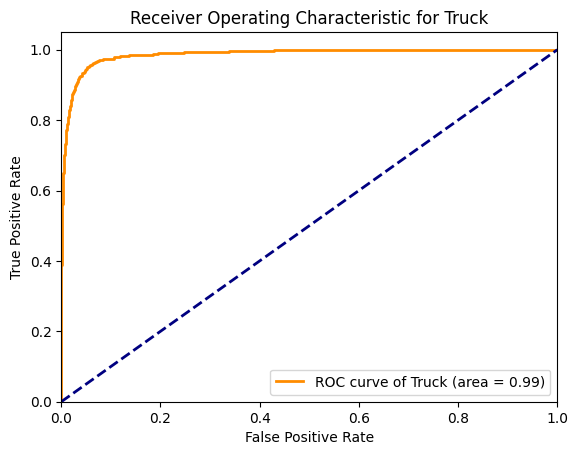

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming test_labels and test_predictions are defined and that test_labels are one-hot encoded

# Prepare ROC curve data
fpr = {}
tpr = {}
roc_auc = {}
for i in range(10):  # CIFAR-10 has 10 classes
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
df

,epoch,accuracy,f1_score,loss,precision,recall,val_accuracy,val_f1_score,val_loss,val_precision,val_recall
0,0,0.66954,0.652340,0.954721,0.763356,0.57154,0.7584,0.748371,0.706574,0.828729,0.6900
1,0,0.62220,0.562841,1.218160,0.706093,0.52772,0.7353,0.725410,0.764427,0.808568,0.6644
2,1,0.67162,0.648343,0.949541,0.761359,0.57440,0.7516,0.750160,0.740281,0.812691,0.6916
3,2,0.68492,0.666653,0.915185,0.773664,0.59060,0.7623,0.761323,0.703200,0.822797,0.7067
4,0,0.62110,0.555292,1.222260,0.706212,0.52230,0.7330,0.733582,0.771538,0.798996,0.6682
5,1,0.67118,0.652907,0.954416,0.763374,0.57250,0.7496,0.741617,0.735027,0.810868,0.6924
6,2,0.68456,0.669964,0.921086,0.773669,0.58918,0.7555,0.760811,0.715891,0.820669,0.6988
7,3,0.69144,0.676650,0.892178,0.778077,0.60052,0.7715,0.771269,0.681112,0.830424,0.7135
8,4,0.69942,0.686759,0.873505,0.781414,0.61316,0.7651,0.761143,0.706734,0.820545,0.7133
9,5,0.70348,0.695041,0.865442,0.786669,0.61656,0.7665,0.761736,0.697679,0.823916,0.7145


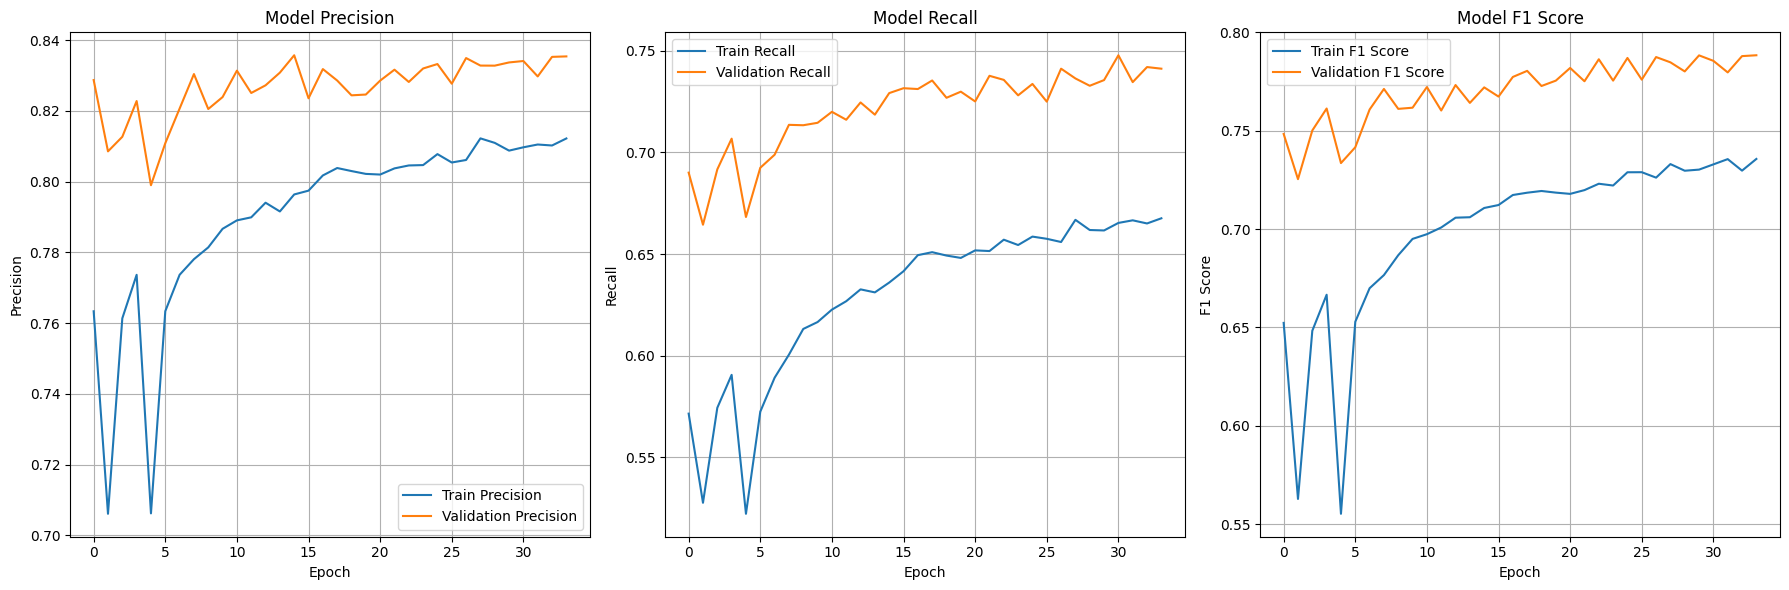

In [ ]:
# Plot Precision, Recall, and F1-score
plt.figure(figsize=(18, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.plot(df['precision'], label='Train Precision')
plt.plot(df['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 2)
plt.plot(df['recall'], label='Train Recall')
plt.plot(df['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(df['f1_score'], label='Train F1 Score')
plt.plot(df['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Predict classes with the maximum probability
predicted_classes = np.argmax(model.predict(test_images), axis=1)
true_classes = np.argmax(test_labels, axis=1)


313/313 [==============================] - 678s 2s/step


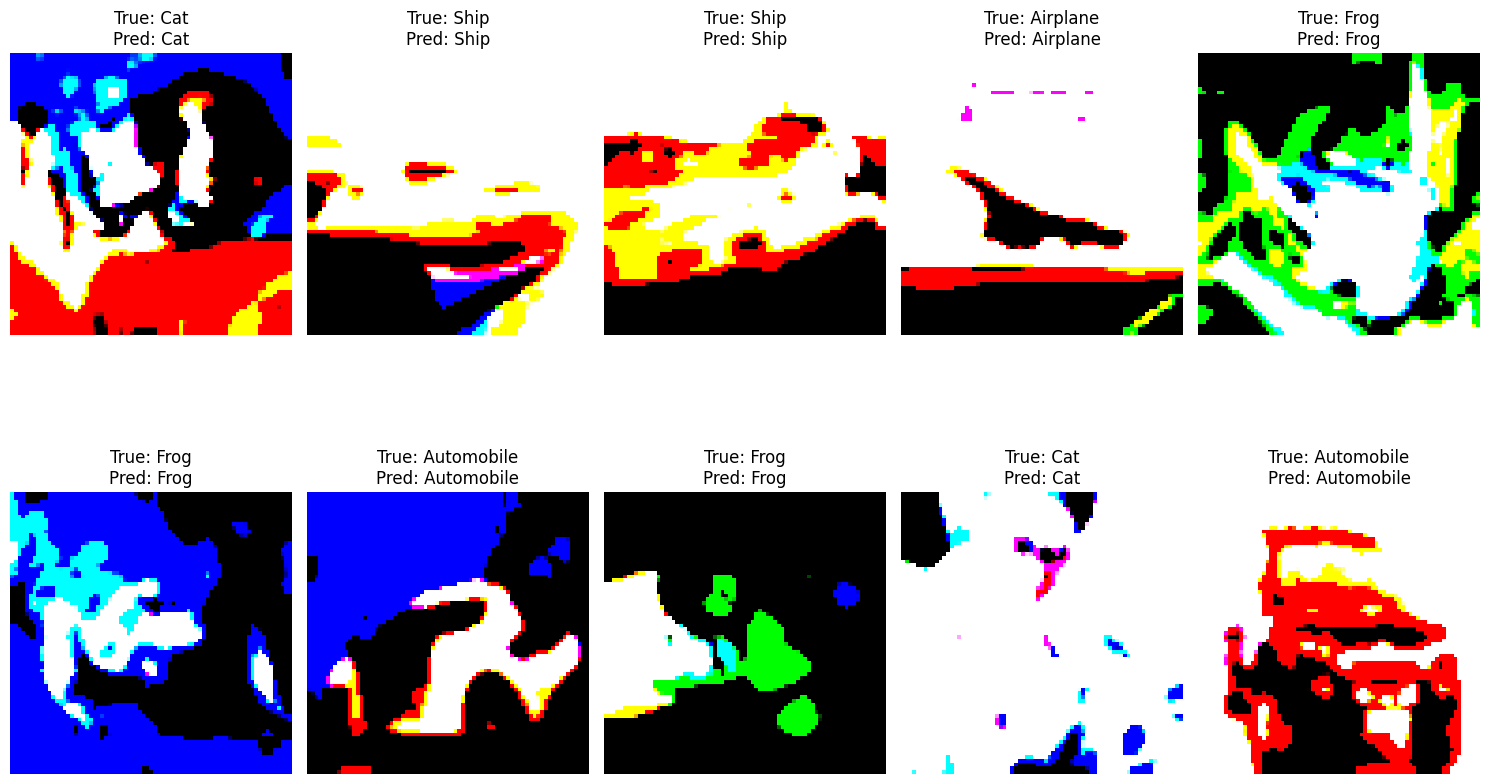

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(10):  # plot 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assume test_images are already preprocessed if needed (e.g., scaling)
# If preprocessing was used (like normalization), you may need to adjust the images to display correctly:
# example: images_to_show = test_images * 255 if images were normalized to [0, 1] range during preprocessing
images_to_show = test_images[:10]  # Select the first 10 images
true_labels = true_classes[:10]   # Select the first 10 true labels
predicted_labels = predicted_classes[:10]  # Select the first 10 predicted labels

plot_images(images_to_show, true_labels, predicted_labels, class_names)
